In [1]:
import pandas as pd
import numpy as np
import wget
from tqdm import tqdm
import cv2 
import matplotlib.pyplot as plt
from PIL import Image
import glob 

import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

2023-05-18 17:47:51.200373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 17:47:53.373818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sac0380/miniconda3/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-18 17:47:53.373867: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sac0380/miniconda3/lib/python3.10/site-packages/cv2/.

## Segmenting Plant Images

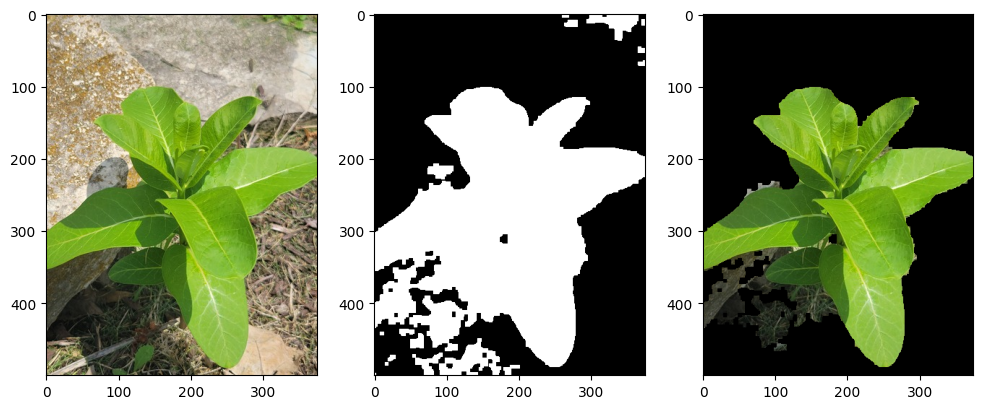

In [2]:
img = cv2.imread("milkweed/images/4170.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

low_green = np.array([30, 0, 0])
high_green = np.array([95, 255, 255])

mask = cv2.inRange(hsv, low_green, high_green)

kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel) 
mask = cv2.erode(mask, kernel) 
mask = cv2.dilate(mask, kernel) 

res = cv2.bitwise_and(img,img, mask= mask)

nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(mask)
sizes = stats[:, -1]
sizes = sizes[1:]
nb_blobs -= 1

min_size = 20500  

im_result = np.zeros_like(im_with_separated_blobs)
for blob in range(nb_blobs):
    if sizes[blob] >= min_size:
        im_result[im_with_separated_blobs == blob + 1] = 255

res = cv2.bitwise_and(img,img, mask= np.array(im_result).astype(np.uint8))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,10))
fig.tight_layout()
ax1.imshow(img)
ax2.imshow(255 - mask, cmap="Greys")
ax3.imshow(res)

## Greenness Identification

/tmp/ipykernel_327334/298038452.py:7: RuntimeWarning: divide by zero encountered in divide
  VEG = img[:, :, 1] / ((img[:, :, 0]**0.667)*(img[:, :, 2]**0.333))


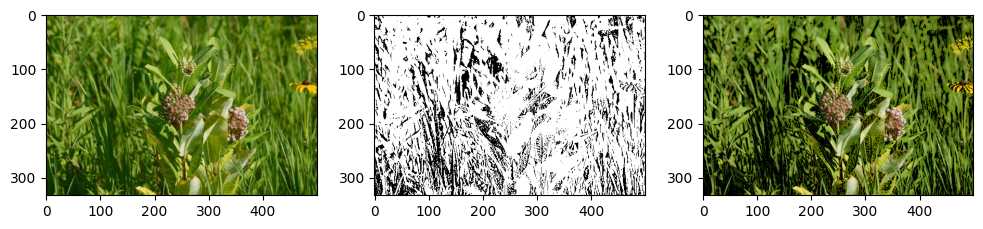

In [3]:
img = cv2.imread("milkweed/images/4198.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255

ExG = 2*img[:, :, 1] - img[:, :, 0] - img[:, :, 2]
ExGR = ExG - (1.4*img[:, :, 0] - img[:, :, 1])
VEG = img[:, :, 1] / ((img[:, :, 0]**0.667)*(img[:, :, 2]**0.333))
CIVE = (0.441*img[:, :, 0]) - (0.881*img[:, :, 1]) + (0.385*img[:, :, 2]) + 18.78745
COM = (0.25*ExG) + (0.30*ExGR) + (0.33*CIVE) + (0.12*VEG)

mask = np.where(COM < 7, 1, 0)

res = cv2.bitwise_and(img,img, mask= np.array(mask).astype(np.uint8))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,10))
fig.tight_layout()
ax1.imshow(img)
ax2.imshow(255 - mask, cmap="Greys")
ax3.imshow(res)